<img src="../resources/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Tutorial on Generalized Linear Models (GLM) </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Tuesday, August 30, 2022</h3> 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> As scientists, we want to build models of data that are as simple as possible, and are able to explain the data as well as possible. Sometimes, when linear regression doesn't cut it and more complicated nonlinear models are too difficult to fit and/or analyze, Genaralized Linear Models (GLM) can be a good choice. They have also been used a lot to model neural responses to stimuli, as we will do in this notebook.</p>

<p>
The GLM is defined as follows for some input $\vec{x}_i$ and output $y_i$:
</p>
<p>
$P(y_i|\vec{x}_i;\vec{w}) = F(g^{-1}(\vec{w}\cdot\vec{x}_i))$
</p>
    
<p>
Where $g$ is called the "link function", $F(m)$ represents some probability distribution with mean $m$, and $\vec{w}$ is a vector of fitted parameters. These parameters are fitted by finding the $\vec{w}$ that maximizes $\prod_{i=1}^N P(y_i|\vec{x}_i;\vec{w})$ for some dataset of $N$ samples. Note that when $g$ is the identity, and $F$ is the normal distribution with some fixed variance, this is just a linear regression problem. When $g$ is logit (inverse of the sigmoid function), and $F$ is the Bernoulli distribution, this is logistic regression.
</p>
   
<p>
In this tutorial, we will use the statsmodels package (https://www.statsmodels.org/stable/glm.html) to fit parameters for GLMs, since it is simple and fast. However, some instances of GLM are available in the sci-kit learn package, e.g. PoissonRegressor, TweedieRegressor, GammaRegressor, and of course LogisticRegression and LinearRegression from sklearn.linear_model (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model).
</p> 
    
<p>
In order to use this package, we must supply $y_i$ and $\vec{x}_i$ for all $i$. Statsmodels expects a "design matrix" of inputs, </p>
    
$$\begin{bmatrix} \vec{x}_1^T \\ \vdots \\ \vec{x}_N^T \end{bmatrix}$$
<p> and a vector of outputs, </p>
$$\begin{bmatrix} y_{1} \\ \vdots \\ y_{N}\end{bmatrix}$$
    
</div>

In [1]:
# !conda install --yes statsmodels
# !conda install --yes -c conda-forge numpy=1.22

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd

%matplotlib inline

We'll use the statsmodels package to fit GLMs.

In [3]:
import statsmodels.api as sm

Let's explore the GLM functionality using a dataset much more exciting than neuroscience...

In [4]:
df = pd.read_csv('Data/pokemon_alopez247.csv')

In [5]:
df.head()

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


As an example (modern cultural/gender studies project?), let's train a GLM to predict whether or not a pokemon species is gendered.

First, we define our vector of outputs:

In [6]:
y = df.hasGender.values

Next, we define our design matrix of inputs. First, let's select which columns we want to use as predictors:

In [7]:
X_df = df[df.columns[(df.dtypes!='object')
                     &(~df.columns.isin(['Pr_Male','hasGender','Total','Number']))]]
# X_df = pd.get_dummies(df.drop(['Name','Pr_Male','hasGender','Total','Number'],axis='columns'))
X_df.head()

,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate
0,45,49,49,65,65,45,1,False,False,0.71,6.9,45
1,60,62,63,80,80,60,1,False,False,0.99,13.0,45
2,80,82,83,100,100,80,1,False,True,2.01,100.0,45
3,39,52,43,60,50,65,1,False,False,0.61,8.5,45
4,58,64,58,80,65,80,1,False,False,1.09,19.0,45


Now, we use sm.add_constant to add a column of ones (**Question** Why?).

In [8]:
X_dsn = sm.add_constant(X_df.astype(float))
X_dsn = X_dsn/X_dsn.max(axis=0)

Let's take a look at this design matrix:

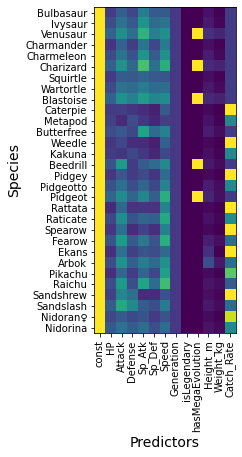

In [9]:
fig,ax = plt.subplots(figsize=(15,6))
n_rows = 30
ax.imshow(X_dsn.values[:n_rows,:]) #looking at only the first 30 species
ax.set_ylabel('Species',fontsize=14)
ax.set_xlabel('Predictors',fontsize=14)
ax.set_yticks(ticks=np.arange(n_rows),labels=df.Name.values[:30])
ax.set_xticks(ticks=np.arange(X_dsn.shape[1]),labels=X_dsn.columns,rotation=90)


Now we're ready to make a GLM model, and fit it to data. The 'family' argument tells statsmodels which distribution to use for the output.

In [10]:
glm = sm.GLM(y,X_dsn,family=sm.families.Binomial())
results = glm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  721
Model:                            GLM   Df Residuals:                      708
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -135.17
Date:                Tue, 30 Aug 2022   Deviance:                       270.35
Time:                        07:33:04   Pearson chi2:                     881.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2626
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.2214      1.447      2.917      0.004       1.385       7.057
HP                   5.7535      2.907      1.979      0.048       0.055      11.452
Attack               0.6058      1.474      0.411      0.681      -2.282       3.494
Defense             -2.3399      1.599     -1.464      0.143      -5.473       0.793
Sp_Atk              -2.9851      1.166     -2.561      0.010      -5.270      -0.700
Sp_Def              -3.1065      1.661     -1.870      0.061      -6.363       0.150
Speed               -1.8864      1.245     -1.515      0.130      -4.327       0.555
Generation           0.6909      0.608      1.137      0.256      -0.500       1.882
isLegendary         -3.9195      0.681     -5.755      0.000      -5.254      -2.585
hasMegaEvolution     2.1060      0.866      2.433      0.015       0.409       3.803
Height_m            10.4754      4.223      2.481      0.013       2.199      18.752
Weight_kg           -9.4866      2.426     -3.911      0.000     -14.241      -4.733
Catch_Rate           0.5129      0.972      0.528      0.598      -1.392       2.418
====================================================================================
"""

Text(0, 0.5, 'Coefficient (MLE $\\pm$ SEM)')

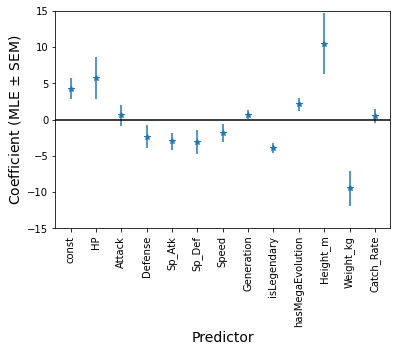

In [11]:
fig,ax = plt.subplots()
ax.errorbar(np.arange(X_dsn.shape[1]),results.params,yerr=results.bse,fmt='*')
ax.axhline(0,color='k')
ax.set_xticks(ticks = np.arange(X_dsn.shape[1]),labels = X_dsn.columns, rotation=90)
ax.set_ylim([-15,15])
ax.set_xlabel('Predictor',fontsize=14)
ax.set_ylabel('Coefficient (MLE $\pm$ SEM)',fontsize=14)


We can interrogate 'results' to evaluate our fitted model:

In [12]:
y_pred = results.predict(X_dsn)>0.5
accuracy = np.mean(y_pred==y)
print('Accuracy: ', accuracy)
print('Average likelihood: ', np.exp(results.llf/X_dsn.shape[0]))

Accuracy:  0.9361997226074896
Average likelihood:  0.8290442917904213


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
    To model neural spiking, $y_i$ will be the number of spikes a neuron fires in time bin $i$, and $\vec{x}_i$ will be a vector of all the predictors used to predict $y_i$. This will include three types of predictors:</p>
   

 1. The stimulus incident on our neuron during time bin $i$, and for $d-1$ time bins leading up to it
    
 2. The spiking history of our neuron for $d$ time bins leading up to time bin $i$
    
 3. A constant $1$ - the corresponding element of $\vec{w}$ will be an offset term

<p>
Each vector will therefore look like this: 
    $\vec{x}_i = [stimulus_i,...,stimulus_{i-d+1},y_{i-1},...,y_{i-d},1]^T$
</p>

<img src="images/GLM_Pillow.png" width="480">

   
<p>   
We refer to the corresponding parts of $\vec{w}$ as the "stimulus filter", "spike history filter", and "offset". Traditionally, when using GLMs to model neural spiking, we use a log link function, i.e. $g^{-1}(a) = e^a$, and a Poisson distribution.
</p>

<p>
For this model, the design matrix looks like this: </p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; font-size: 70%;">
    
$$\begin{bmatrix} \vec{x}_1^T \\ \vdots \\ \vec{x}_N^T \end{bmatrix} = \begin{bmatrix} stimulus_{d+1} & stimulus_{d} & ... & stimulus_{3} & stimulus_{2} & y_{d} & y_{d-1} & ... & y_{2} & y_{1} & 1 \\ stimulus_{d+2} & stimulus_{d+1} & ... & stimulus_{4} & stimulus_{3} & y_{d+1} & y_{d} & ... & y_{3} & y_{2} & 1 \\ \vdots &\vdots & \ddots & \vdots &\vdots &\vdots &\vdots& \ddots & \vdots &\vdots &\vdots\\ stimulus_{d+N} & stimulus_{d+N-1} & ... & stimulus_{N+2} & stimulus_{N+1} & y_{d+N-1} & y_{d+N-2} & ... & y_{N+1} & y_{N} & 1 \end{bmatrix}$$
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">    
    
<p> And the vector of outputs is: </p>
$$\begin{bmatrix} y_{d+1} \\ \vdots \\ y_{d+N}\end{bmatrix}$$
    
</div>

Below, we define a few helper functions to take care of simulating the spiking output of a GLM and fitting a spiking GLM to data (including constructing the design matrix).

In [13]:
def sim_GLM(stim, stim_filt, spk_filt, offset,max_spikes_per_bin=5):
    """
    Simulate a GLM's response to a 1D stimulus
    Inputs:
    stim: The stimulus - np array with shape (T,) 
    stim_filt: Stimulus filter - np array with shape (d,)
    spk_filt: Spike history filter - np array with shape (d,)
    offset: Offset term - scalar
    max_spikes_per_bin: Maximum number of spikes allowed in a single time bin

    Outputs:
    spks: the spiking response - (T,) ndarray
    """
    
    d = stim_filt.size
    T = stim.size
    spks = np.zeros((T,)) # spiking starts at time step d
    rate = np.zeros((T,))
    for i in range(d,T):
        rate[i] = np.exp(np.flip(stim_filt,-1).dot(stim[i-d+1:i+1])
                         +np.flip(spk_filt,-1).dot(spks[i-d:i])
                         +offset)
        spks[i] = np.random.poisson(rate[i])
        spks[i] = min(spks[i],max_spikes_per_bin)
    return spks




def construct_Xdsn(flat_stimulus, binned_spikes, d):
    """
    Construct the design matrix for a given stimulus and spiking response
    Inputs:
    flat_stimulus: the stimulus - an (MxT) ndarray, 
                M is the dimension of the stimulus, 
                T is the number of time samples
    binned_spikes: the spiking response - a (T,) ndarray 
    d: integer - how many time bins of history to use as predictors

    Outputs:
    y: the dependent variable to be predicted (spiking response) - (T-d,) ndarray
    X_dsn: the design matrix of independent variables - 2D ndarray
    """
    
    T = binned_spikes.size # T is number of time bins
    sh = flat_stimulus.shape # M is the size of a stimulus
    if len(sh)==1:
        M = 1
        T1 = sh[0]
        flat_stimulus = np.expand_dims(flat_stimulus,axis=0)
    else:
        (M,T1) = sh  
    assert T==T1, "arrays have a different number of time samples"
    
    y = binned_spikes[d:]
    X_dsn = np.ones((T-d,M*d+d+1)) #the last column is constant 1s
    for t in range(T-d):
        #stimulus inputs
        X_dsn[t,:M*d] = np.flip(flat_stimulus[:,t+1:t+d+1],-1).reshape((1,-1)) 
        #spike history inputs
        X_dsn[t,M*d:-1] = np.flip(binned_spikes[t:t+d],-1).reshape((1,-1)) 
    return y, X_dsn



def fit_GLM(flat_stimulus, binned_spikes, d):
    """
    Fit GLM parameters for a given stimulus and spiking response
    Inputs:
    flat_stimulus: the stimulus - an (MxT) ndarray, 
                    M is the dimension of the stimulus, 
                    T is the number of time samples
    binned_spikes: the spiking response - a (T,) ndarray 
    d: integer - how many time bins of history to use as predictors

    Outputs:
    stim_filt, spk_filt, b: 
            the stimulus filter, spike history filter, and offset term
    stim_se, spk_se, b_se: 
            the standard errors for these parameter estimates
    """
    y, Xdsn = construct_Xdsn(flat_stimulus,binned_spikes,d)
    model =  sm.GLM(y,Xdsn,family = sm.families.Poisson())
    model_results = model.fit()
    pred_rate = model_results.predict(Xdsn)
    p = model_results.params
    se = model_results.bse
    
    b = p[-1]
    b_se = se[-1]
    stim_filt = p[:-1-d]
    stim_se = se[:-1-d]
    spk_filt = p[-1-d:-1]
    spk_se = se[-1-d:-1]
    if stim_filt.size>d:
        stim_filt = stim_filt.reshape([-1,d])
        stim_se = stim_se.reshape([-1,d])
    return stim_filt, spk_filt, b, stim_se, spk_se, b_se

Now let's play around with simulating a GLM with some hand-picked parameters.

Text(0.5, 0, 'time (bins)')

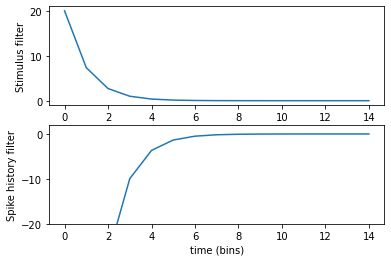

In [14]:
d = 15 #how long our filters are (time bins)
t_f = np.arange(d)
spk_filt = -200*np.exp(-t_f/1.0) # self-interaction filter
stim_filt = 20*np.exp(-t_f/1.0)  # stimulus filter
b = -15.5 #offset

fig, ax = plt.subplots(2,1)
ax[0].plot(stim_filt,label='true')
ax[0].set_ylabel('Stimulus filter')
ax[1].plot(spk_filt,label='true')
ax[1].set_ylabel('Spike history filter')
ax[1].set_ylim([-20,2])
ax[1].set_xlabel('time (bins)')

Let's simulate a random Gaussian stimulus to feed into our GLM, and simulate the spiking response

Text(0.5, 0, 'time (samples)')

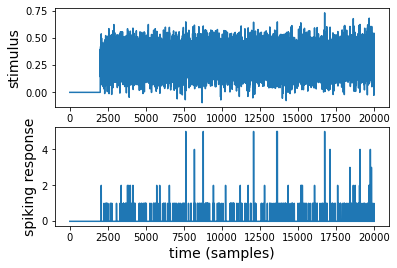

In [15]:
T = 20000
stim = np.random.normal(loc=0.3, scale=0.1,size=(T,))
# stim = (1+np.sin(np.arange(T)/200))*0.2
stim[0:T//10] = 0
spks = sim_GLM(stim,stim_filt,spk_filt,b)

fig,ax = plt.subplots(2,1)
ax[0].plot(stim)
ax[0].set_ylabel('stimulus',fontsize=14)

ax[1].plot(spks)
ax[1].set_ylabel('spiking response',fontsize=14)
ax[1].set_xlabel('time (samples)',fontsize=14)

Now let's use our fit_GLM function to see how well we can recover the true parameters. First, let's make and take a look at our design matrix:

Text(0, 0.5, 'sample')

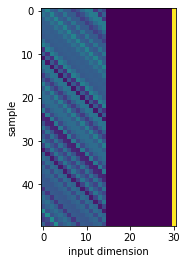

In [16]:
y, Xdsn = construct_Xdsn(stim,spks,d)
plt.imshow(Xdsn[6000:6050,:])
plt.xlabel('input dimension')
plt.ylabel('sample')

**Question:** If we wanted to split our data into train, validation, and test sets, should we shuffle the time points?


Now, let's fit the GLM and take a look at the fitted parameters:

true offset = -15.5  fit offset = -15.417434729934648 +/- 0.7461843000162521


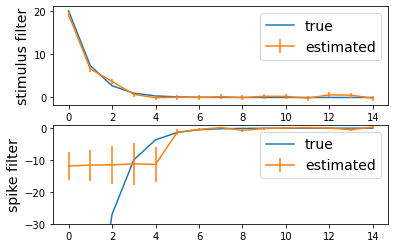

In [17]:
stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se = fit_GLM(stim,spks,d)
fig,ax = plt.subplots(2,1)
ax[0].plot(stim_filt,label='true')
ax[0].errorbar(np.arange(d),stim_filt_fit,yerr=stim_se,label='estimated')
ax[0].legend(fontsize=14)
ax[0].set_ylabel('stimulus filter',fontsize=14)

ax[1].plot(spk_filt,label='true')
ax[1].errorbar(np.arange(d),spk_filt_fit,yerr=spk_se,label='estimated')
ax[1].legend(fontsize=14)
ax[1].set_ylabel('spike filter',fontsize=14)
ax[1].set_ylim([-30,1])

print('true offset =', b, ' fit offset =', b_fit, '+/-', b_se)

**Question:** Why is the estimated spike filter "bottoming out"?

Now let's practice fitting a GLM to Neuropixels data

In [18]:
import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

In [19]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

# this path should point to the location of the dataset on your platform
cache_dir = os.path.join(data_root, data_dirname)

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=use_static)

In [20]:
session_id = 1065437523  # This is the same session we used in the VBN intro
session = cache.get_ecephys_session(ecephys_session_id=session_id)

/srv/conda/envs/notebook/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


For now, let's stick with a simple stimulus, flashes

In [21]:
stimulus_presentations = session.stimulus_presentations
stim_table = stimulus_presentations[stimulus_presentations.stimulus_name=='flash_250ms']

In [22]:
len(stim_table)

150

In [23]:
stim_table.head()

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,orientation,...,position_y,rewarded,spatial_frequency,start_frame,start_time,stimulus_block,stimulus_index,stimulus_name,stop_time,temporal_frequency
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
8444,False,-1.0,0.8,0.250201,288601,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,288586,4859.225759,4,1.0,flash_250ms,4859.475960,NaN
8445,False,1.0,0.8,0.250216,288721,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,288706,4861.227399,4,1.0,flash_250ms,4861.477615,NaN
8446,False,1.0,0.8,0.250208,288841,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,288826,4863.229099,4,1.0,flash_250ms,4863.479307,NaN
8447,False,-1.0,0.8,0.250211,288961,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,288946,4865.230769,4,1.0,flash_250ms,4865.480980,NaN
8448,False,-1.0,0.8,0.250211,289081,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,289066,4867.232469,4,1.0,flash_250ms,4867.482680,NaN


We need to make a choice about how represent the stimulus during each time bin as a vector. for now, we'll choose 20ms bins with a scalar value:
 - +1 if a bright flash takes up most of the bin
 - -1 if a dark flash takes up most of the bin
 - 0 otherwise
 
 First, let's figure out the timestamps of the data we want to use:

In [24]:
flashes = 150
start = np.round(stim_table.start_time.iloc[0]-0.3,decimals=2)
stop = np.round(stim_table.stop_time.iloc[flashes-1]+0.3,decimals=2)
dt = 0.02
T = int((stop-start)/dt)
print(start,stop,T)

4858.93 5158.03 14954


Next, go through each flash and fill in the stimulus vector during that flash with the appropriate value.

(4858.93, 4888.93)

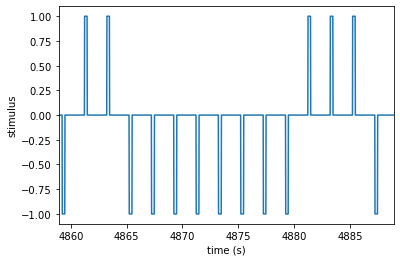

In [25]:
time_vector = np.arange(T)*dt+start
stim_vector = np.zeros((T,))
stim_matrix = np.zeros((2,T))
for flash in range(flashes):
    start_bin = int(np.round((stim_table.start_time.iloc[flash]-start)/dt))
    stop_bin = int(np.round((stim_table.stop_time.iloc[flash]-start)/dt))
    stim_vector[start_bin:stop_bin] = stim_table.color.iloc[flash]
    stim_matrix[int(stim_table.color.iloc[flash]>0),start_bin:stop_bin] = 1
plt.plot(time_vector,stim_vector.T)
plt.xlabel('time (s)')
plt.ylabel('stimulus')
plt.xlim(time_vector[0],time_vector[0]+30)

Now let's pick a single neuron and count how many times it spikes in each of these bins

In [26]:
units = session.get_units()
channels = session.get_channels()
units = units.merge(channels, left_on='peak_channel_id', right_index=True)

unit_id = units[units.structure_acronym=='VISp'].index[12] #interesting neurons: 12,13,15,17,20

(4858.93, 4888.93)

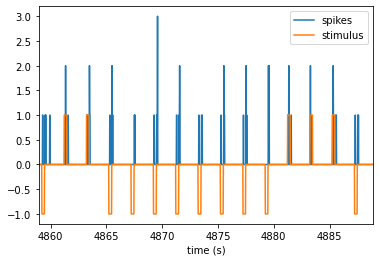

In [27]:
spk_vector = np.zeros_like(stim_vector)
for spike_time in session.spike_times[unit_id]:
    if (spike_time>start) and (spike_time<stop):
        spk_bin = int((spike_time-start)/dt)
        spk_vector[spk_bin] += 1   

plt.xlabel('time (s)')
plt.plot(time_vector,spk_vector,label='spikes')
plt.plot(time_vector,stim_vector,label='stimulus')
plt.legend()
plt.xlim(time_vector[0],time_vector[0]+30)

Now let's fit a GLM to this data and see what the parameters look like

estimated offset =  -4.422665900253607  $\pm$  0.07971065829018141


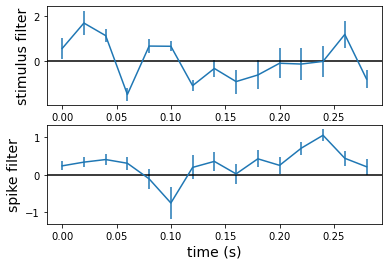

In [28]:
d = 15
tuple_of_params = fit_GLM(stim_vector,spk_vector,d) #stim_vector or stim_matrix
stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se = tuple_of_params
fig,ax = plt.subplots(2,1)

if len(stim_filt_fit.shape)==1:
    ax[0].errorbar(np.arange(d)*dt,stim_filt_fit,yerr=stim_se)
else:
    ax[0].errorbar(np.arange(d)*dt,stim_filt_fit[0,:],yerr=stim_se[0,:],label='black')
    ax[0].errorbar(np.arange(d)*dt,stim_filt_fit[1,:],yerr=stim_se[1,:],label='white')
    ax[0].legend()
ax[0].axhline(c='k')
ax[0].set_ylabel('stimulus filter',fontsize=14)

ax[1].errorbar(np.arange(d)*dt,spk_filt_fit,yerr=spk_se,label='estimated')
ax[1].axhline(c='k')
ax[1].set_ylabel('spike filter',fontsize=14)
ax[1].set_xlabel('time (s)',fontsize=14)
# ax[1].set_ylim([-3,3])

print('estimated offset = ', b_fit, ' $\pm$ ', b_se)